In [1]:
pip install pca

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster import hierarchy
from scipy import stats
import logging, sys
logging.disable(sys.maxsize)
#https://erdogant.github.io/pca
from pca import pca
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


Import Data

In [3]:
import pandas as pd
akuna_data = pd.read_csv("data/akuna_data.csv",)

print("DataFrame: akuna_data")
akuna_data.head(8)

DataFrame: akuna_data


,Submission ID,Respondent ID,Submitted at,In che lingua preferisci svolgere questo sondaggio? - \nIn which language would you prefer to take the survey?,Hai mai acquistato delle scarpe da calcio?,Qual è il tuo genere?,Che lavoro fai?,Da dove provieni?,Quanti anni hai?,"Di solito, in che ruolo giochi?",...,Performance (10),Quality (5),At what price would the product seem so low in quality that you would no longer consider buying it?\n,At what price would the product start to seem like a very good deal?\n,At what price would you start to consider the product too expensive?\n,At what price would the product be so expensive that you would no longer consider buying it?\n,At what price would the product seem so low in quality that you would no longer consider buying it?\n (2),At what price would the product start to seem like a very good deal?\n (2),At what price would you start to consider the product too expensive?\n (2),At what price would the product be so expensive that you would no longer consider buying it?\n (2)
0,rjXaBGX,PdANzXP,2026-02-05 14:27:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,jaK66l4,yPlbJQp,2026-02-05 14:29:56,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,35.0,50.0,80.0,100.0,35.0,50.0,80.0,100.0
2,44ZJJyr,WOA6zzN,2026-02-05 14:31:37,Italiano,Sì,Maschio,Dipendente,Puglia,30.0,Centrocampista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZjxEEMz,zxKAYZq,2026-02-05 14:32:21,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,15.0,25.0,75.0,100.0,15.0,25.0,80.0,120.0
4,GxM998j,yPlbYE0,2026-02-05 14:32:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RGOMoxP,yPlbYeW,2026-02-05 14:33:04,Italiano,Sì,Maschio,Studente,Puglia,24.0,Difensore,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RGOMD2J,442Yx9b,2026-02-05 14:38:07,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25.0,50.0,100.0,150.0,25.0,50.0,100.0,150.0
7,GxM9l2Q,aQB16rb,2026-02-05 14:42:44,Italiano,Sì,Maschio,Studente,Lombardia,24.0,Attaccante,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Segmentation
Import Segmentation Data

Dataset Info

In [4]:

akuna_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Columns: 110 entries, Submission ID to At what price would the product be so expensive that you would no longer consider buying it?
 (2)
dtypes: float64(86), str(24)
memory usage: 100.7 KB


In [5]:
ita_indices = range(14, 23)
eng_indices = range(67, 85)

clean_names = [
    "Boot weight", "Softness of material", "Foot Fit", "Durability", 
    "Brand Reputation", "Ball control", "Ease of fit", "Color options", "Quality Preference"
]
akuna_segmentation_data = pd.DataFrame()

for i in range(len(clean_names)):
    ita_col_name = akuna_data.columns[ita_indices[i]]
    eng_col_name = akuna_data.columns[eng_indices[i]]
    akuna_segmentation_data[clean_names[i]] = akuna_data[eng_col_name].combine_first(akuna_data[ita_col_name])

akuna_segmentation_data.dropna(inplace=True)
print(akuna_segmentation_data.head())

   Boot weight  Softness of material  Foot Fit  Durability  Brand Reputation  \
1          2.0                   2.0       5.0         4.0               5.0   
2          3.0                   3.0       5.0         5.0               2.0   
3          2.0                   4.0       5.0         5.0               4.0   
5          2.0                   3.0       5.0         4.0               3.0   
6          3.0                   1.0       5.0         5.0               2.0   

   Ball control  Ease of fit  Color options  Quality Preference  
1           5.0          5.0            2.0                 5.0  
2           2.0          2.0            1.0                 2.0  
3           4.0          2.0            1.0                 4.0  
5           5.0          1.0            1.0                 5.0  
6           3.0          5.0            1.0                 4.0  


dataset description

In [6]:
akuna_segmentation_data.describe().style.format("{:.1f}")

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference
count,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
mean,3.0,3.9,4.5,4.1,2.4,3.9,2.4,1.9,3.8
std,1.0,1.0,0.7,0.9,1.2,1.2,1.3,1.1,1.1
min,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,2.0,3.0,4.0,4.0,1.0,3.0,1.0,1.0,3.0
50%,3.0,4.0,5.0,4.0,2.0,4.0,2.0,2.0,4.0
75%,4.0,5.0,5.0,5.0,3.0,5.0,3.0,3.0,5.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


clustering

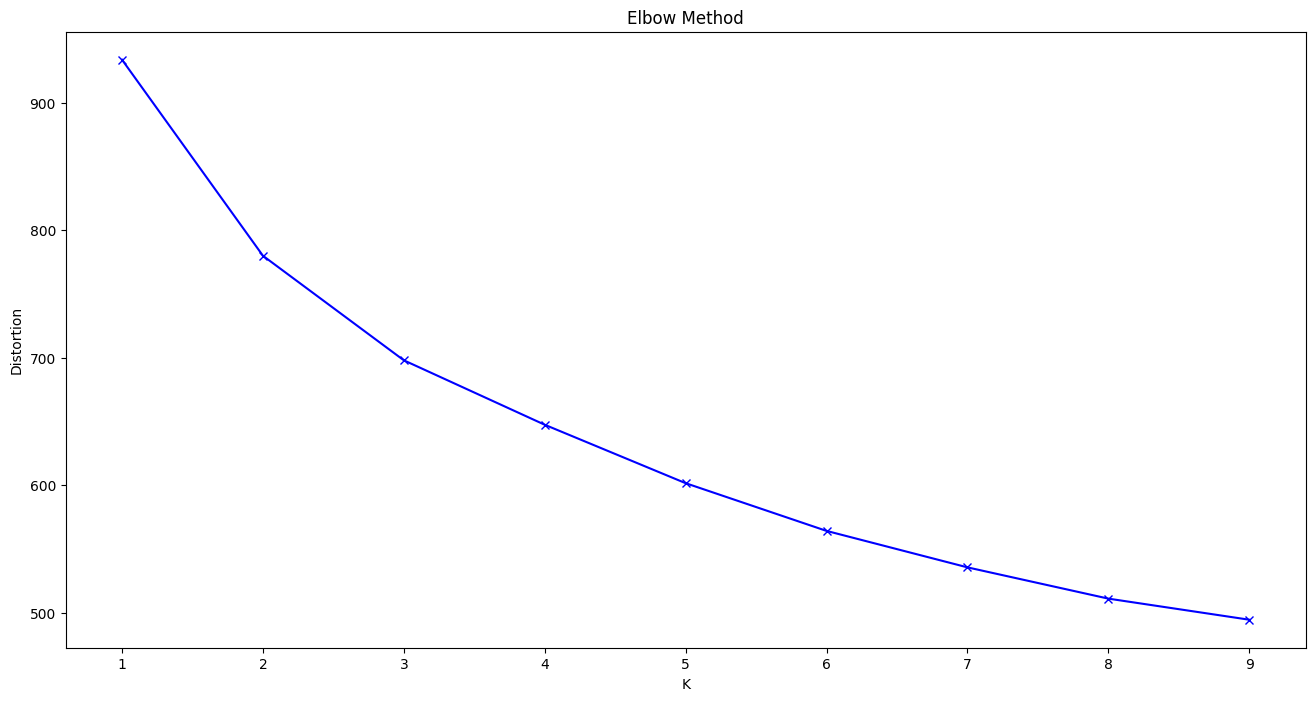

In [7]:
warnings.filterwarnings("ignore")

distortions = [KMeans(n_clusters=K).fit(akuna_segmentation_data).inertia_ for K in range(1,10)]
    
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('K'); plt.ylabel('Distortion'); plt.title('Elbow Method');

Silhouette Analysis

For n_clusters = 2 The average silhouette_score is : 0.13835851547348088
For n_clusters = 3 The average silhouette_score is : 0.09385088080420913
For n_clusters = 4 The average silhouette_score is : 0.1024171323031649
For n_clusters = 5 The average silhouette_score is : 0.10565213900431537


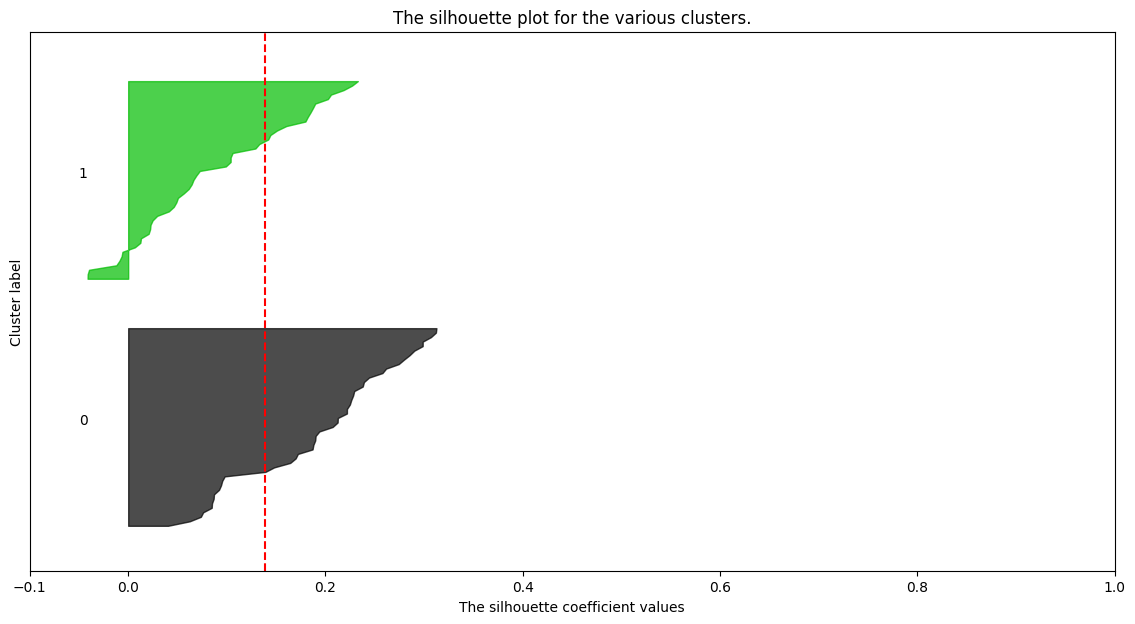

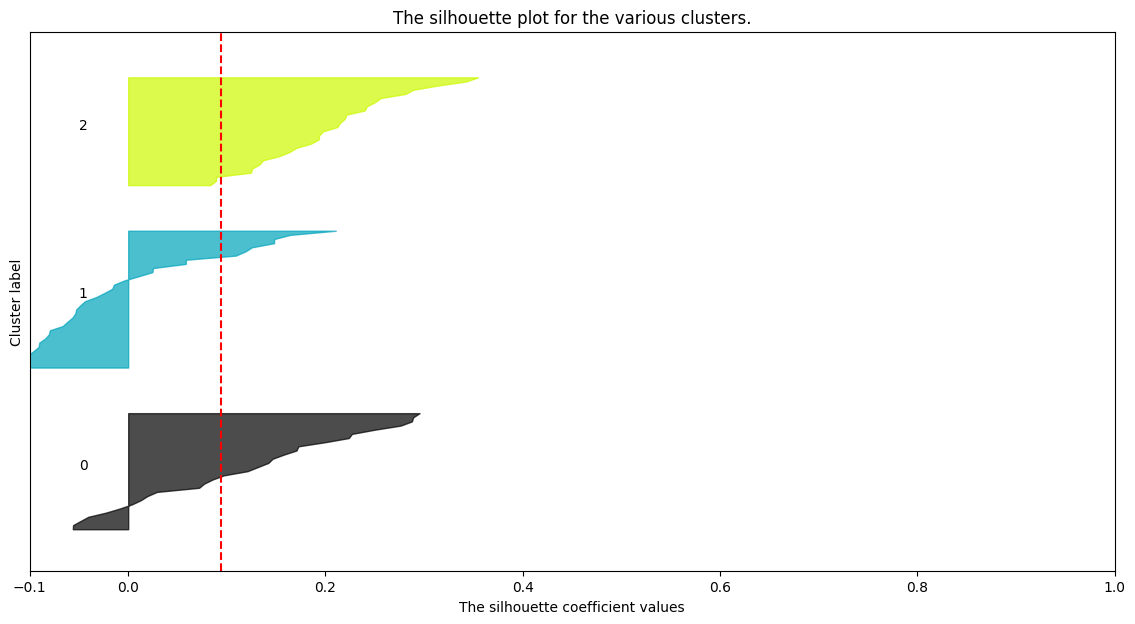

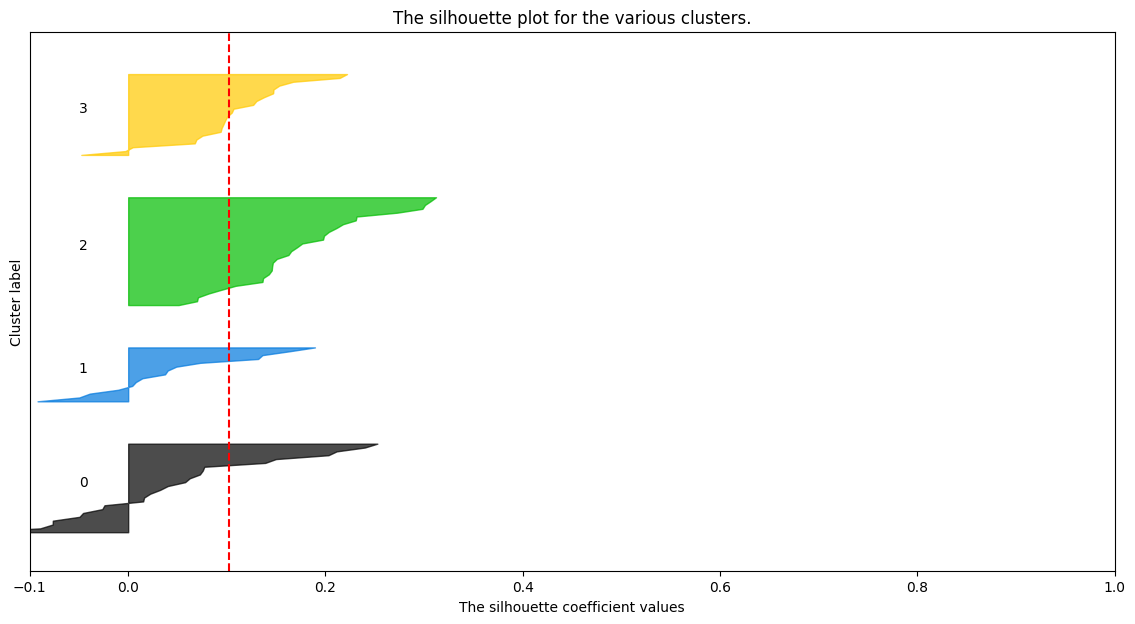

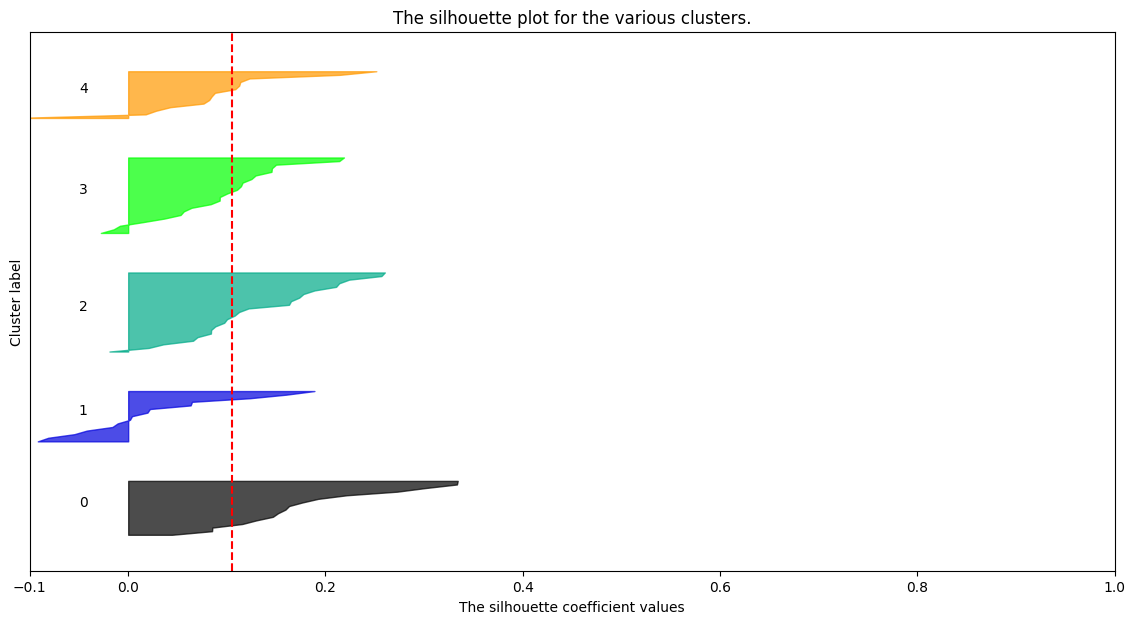

In [8]:
X = akuna_segmentation_data.to_numpy()
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)

    # Silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Silhouette plots show weak structure: most coefficients are close to 0 (some negative), so clusters overlap heavily.
Average silhouette decreases as k increases; k=2 appears relatively best but still indicates only coarse segmentation.

n Segments solution using K-Means

In [9]:
# Perform clustering with K=n, relabel cluster to [1,2,3], add cluster labels back to dataset and show first 8 rows
akuna_segmentation_data["SegmentKM"] = KMeans(n_clusters=3,random_state=42).fit(akuna_segmentation_data).labels_
akuna_segmentation_data["SegmentKM"] = akuna_segmentation_data["SegmentKM"] + 1
akuna_segmentation_data.head(8)

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference,SegmentKM
1,2.0,2.0,5.0,4.0,5.0,5.0,5.0,2.0,5.0,1
2,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,2
3,2.0,4.0,5.0,5.0,4.0,4.0,2.0,1.0,4.0,2
5,2.0,3.0,5.0,4.0,3.0,5.0,1.0,1.0,5.0,2
6,3.0,1.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,3
7,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,2
9,4.0,4.0,3.0,5.0,2.0,5.0,2.0,1.0,4.0,2
13,4.0,3.0,4.0,5.0,2.0,5.0,3.0,2.0,4.0,3


In [10]:
# Segment sizes 
akuna_segmentation_data_Sizes = pd.DataFrame(akuna_segmentation_data.groupby("SegmentKM").size(),columns=["Size"]).T
akuna_segmentation_data_Sizes.insert(0,"Population",len(akuna_segmentation_data))
akuna_segmentation_data_Sizes.loc["%"] = akuna_segmentation_data_Sizes.iloc[0].div(akuna_segmentation_data_Sizes.iloc[0,0]).mul(100).astype(int)
akuna_segmentation_data_Sizes

SegmentKM,Population,1,2,3
Size,90,20,45,25
%,100,22,50,27


Segments description

In [11]:
akuna_segmentation_data_Means = akuna_segmentation_data.groupby("SegmentKM").mean().T
akuna_segmentation_data_Means.insert(0,"Population",akuna_segmentation_data.drop(columns="SegmentKM").mean())
akuna_segmentation_data_Means.round(2)

SegmentKM,Population,1,2,3
Boot weight,2.98,3.35,2.76,3.08
Softness of material,3.90,4.25,3.73,3.92
Foot Fit,4.49,4.70,4.47,4.36
Durability,4.14,4.35,4.16,3.96
Brand Reputation,2.40,3.70,2.07,1.96
Ball control,3.89,4.55,3.67,3.76
Ease of fit,2.41,2.95,1.47,3.68
Color options,1.93,3.15,1.36,2.00
Quality Preference,3.77,4.50,3.31,4.00


In [12]:
# Significance of means differences between each segment and the rest of the population
# Using appropriate t-test imported from scipy or statsmodel package and setting colors using DataFrame’s style attribute
from scipy import stats
#from statsmodels.stats import weightstats as st

X = akuna_segmentation_data.copy()

def style_cols(col):
    if col.name == "Population": return ["background-color: white"]*len(col)
    
    segment = X[X.SegmentKM == col.name]
    rest_pop = X[X.SegmentKM != col.name]
    
    colors = []
    for var_name, var_segment_mean in col.items():
        t_test, p_value = stats.ttest_ind(segment[var_name], rest_pop[var_name],equal_var=False)
        #_,p_value,_ = st.ttest_ind(segment[var_name],rest_pop[var_name],usevar="unequal")    
        if p_value < 0.05:
            color = "background-color: green" if var_segment_mean > rest_pop[var_name].mean() else "background-color: red"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if var_segment_mean > rest_pop[var_name].mean() else "background-color: #f1807e"
        else: color = "background-color: white"
        colors.append(color)
    return colors

akuna_segmentation_data_Means.style.apply(style_cols).format("{:.2f}")

SegmentKM,Population,1,2,3
Boot weight,2.98,3.35,2.76,3.08
Softness of material,3.90,4.25,3.73,3.92
Foot Fit,4.49,4.70,4.47,4.36
Durability,4.14,4.35,4.16,3.96
Brand Reputation,2.40,3.70,2.07,1.96
Ball control,3.89,4.55,3.67,3.76
Ease of fit,2.41,2.95,1.47,3.68
Color options,1.93,3.15,1.36,2.00
Quality Preference,3.77,4.50,3.31,4.00


Cell colors indicate mean differences vs population: strong colors p<0.05, lighter colors 0.05<=p<0.10; green/red denote higher/lower importance.
* Segment 1: Performance-oriented profile, with significantly higher importance placed on ball control, foot fit, durability, and overall quality.
* Segment 2: Low-engagement profile, consistently assigning lower importance to brand, ease of fit, color options, and quality-related attributes.
* Segment 3: Comfort- and fit-focused profile, emphasizing ease of fit and material softness, with less emphasis on brand reputation.

Segmentation space using PCA (with pca package)

ValueError: assignment destination is read-only

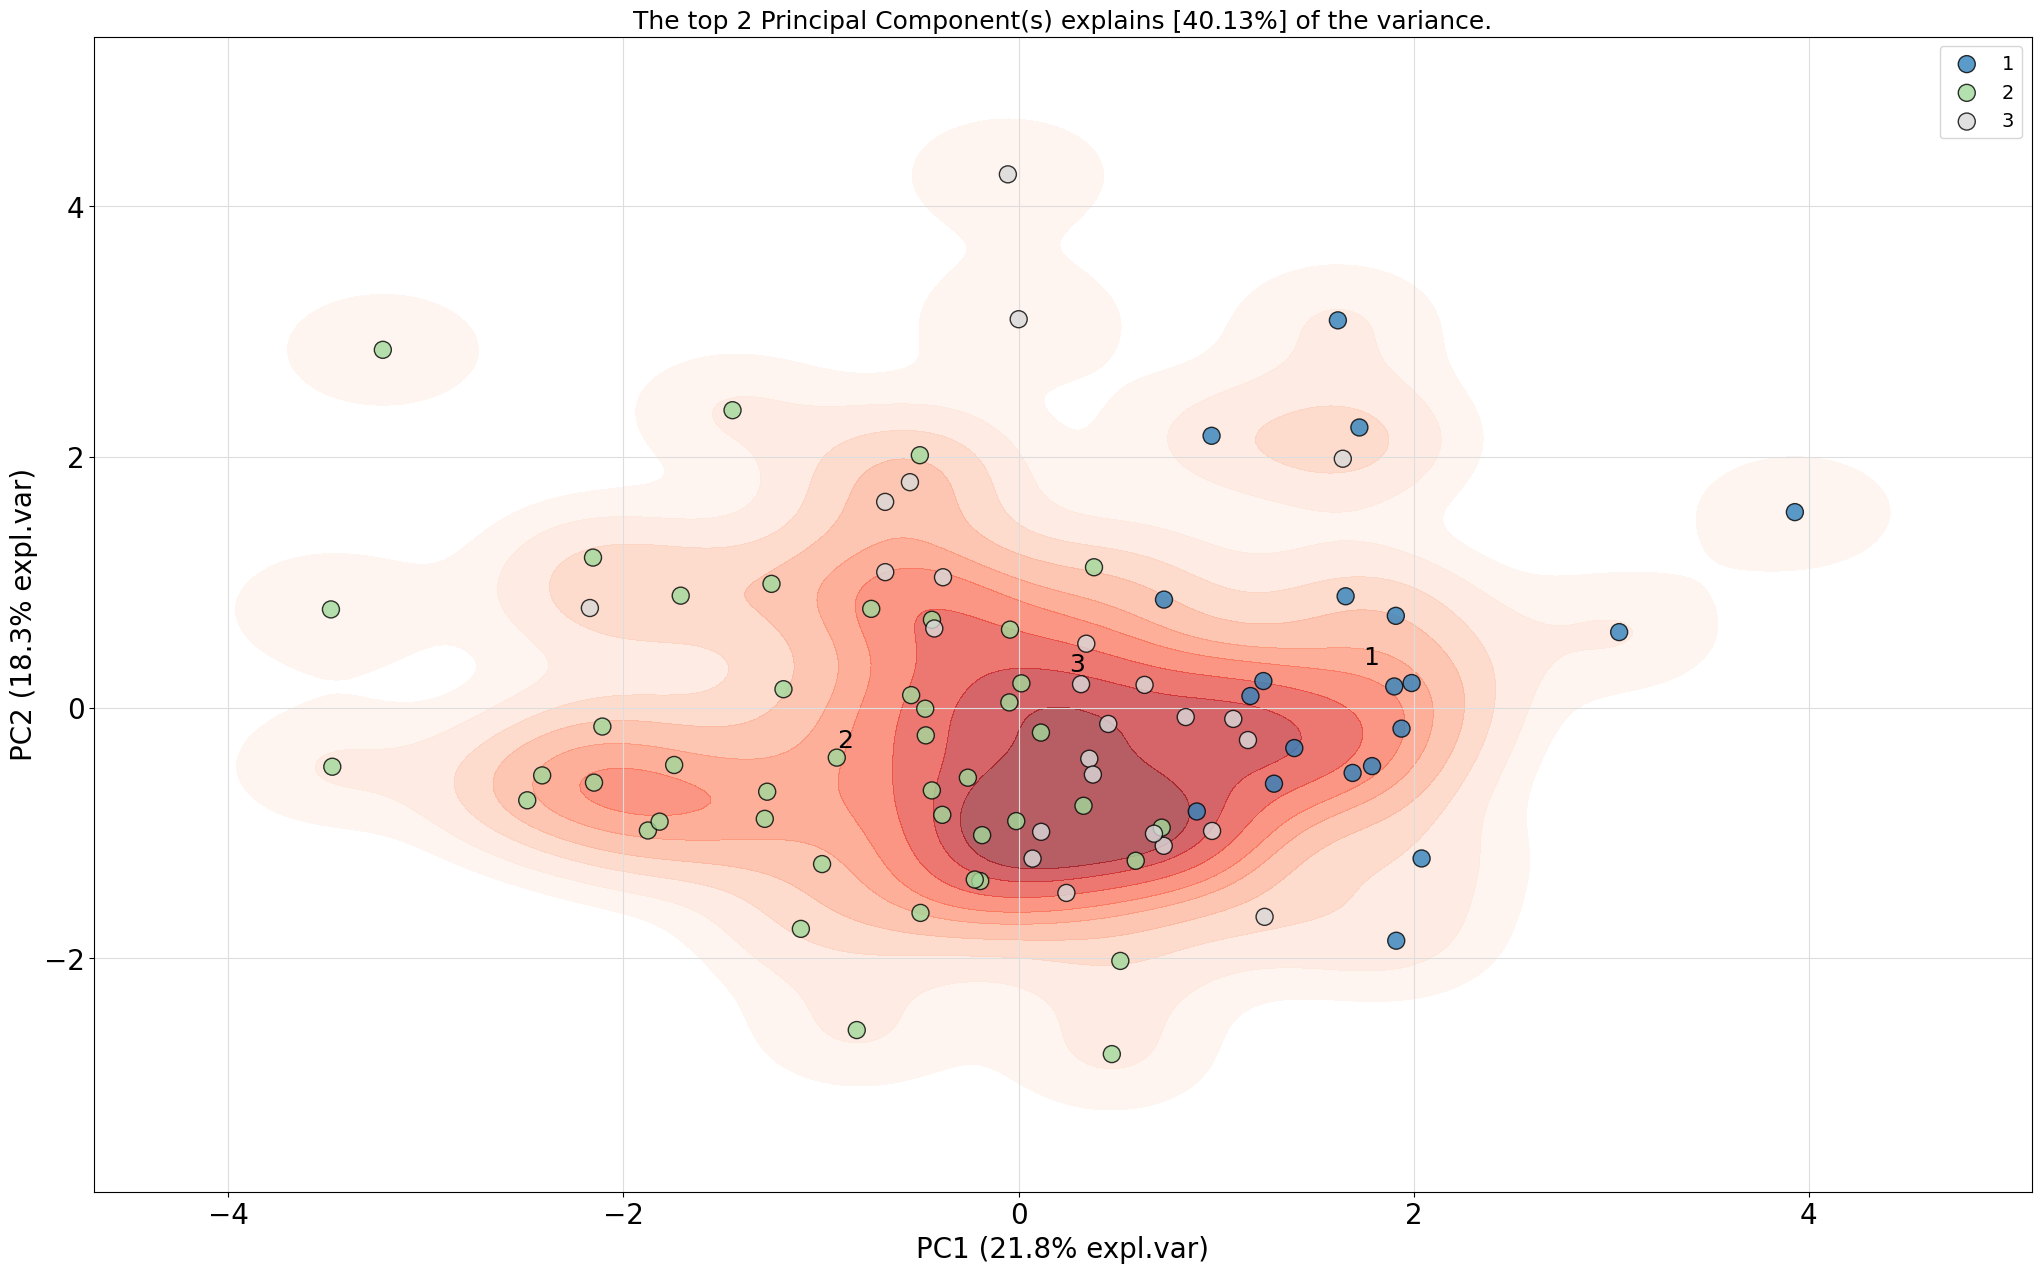

In [13]:
model = pca(n_components=2,normalize=True)
features = akuna_segmentation_data.drop(columns="SegmentKM")
segments = akuna_segmentation_data.SegmentKM

# Fit transform
results = model.fit_transform(features,verbose=False)
# Make biplot with the number of features
# Strenght of the loadings are shown in two colors (red=strong, blue=weak)
fig, ax = model.biplot(labels=segments,verbose=0,density=True);

PCA biplot (PC1 on X, PC2 on Y): the first two PCs explain ~40% of total variance, indicating moderate dimensionality reduction.
* PC1 (left→right) contrasts technical/on-field priorities (durability, softness, lightness, fit, ball control) with aesthetic/brand + easy-wear cues (brand reputation, color options, ease of fit, perceived quality).
* PC2 (bottom→top) captures a secondary “style/brand & convenience” vs “pure performance feel” gradient.

Clusters overlap in the PC1–PC2 plane, consistent with weak separation (low silhouette) and soft preference profiles.

n Segments solution using Hierarchical Clustering

In [14]:
hc = AgglomerativeClustering(n_clusters = 3,linkage="ward")
hc.fit(akuna_segmentation_data)

akuna_segmentation_data["SegmentHC"] = hc.labels_ + 1
akuna_segmentation_data.head(8)

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference,SegmentKM,SegmentHC
1,2.0,2.0,5.0,4.0,5.0,5.0,5.0,2.0,5.0,1,2
2,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,2,3
3,2.0,4.0,5.0,5.0,4.0,4.0,2.0,1.0,4.0,2,3
5,2.0,3.0,5.0,4.0,3.0,5.0,1.0,1.0,5.0,2,3
6,3.0,1.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,3,1
7,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,2,3
9,4.0,4.0,3.0,5.0,2.0,5.0,2.0,1.0,4.0,2,1
13,4.0,3.0,4.0,5.0,2.0,5.0,3.0,2.0,4.0,3,1


In [15]:
(akuna_segmentation_data.groupby("SegmentKM")["SegmentHC"].nunique()==1).all() and \
(akuna_segmentation_data.groupby("SegmentHC")["SegmentKM"].nunique()==1).all()

np.False_

Segments sizes

In [16]:
akuna_segmentation_data_SizesHC = pd.DataFrame(akuna_segmentation_data.groupby("SegmentHC").size(),columns=["Size"]).T
akuna_segmentation_data_SizesHC.insert(0,"Population",len(akuna_segmentation_data))
akuna_segmentation_data_SizesHC.loc["%"] = akuna_segmentation_data_SizesHC.iloc[0].div(akuna_segmentation_data_SizesHC.iloc[0,0]).mul(100).astype(int)
akuna_segmentation_data_SizesHC

SegmentHC,Population,1,2,3
Size,90,31,19,40
%,100,34,21,44


Dendrogram (Ward method) using scipy package

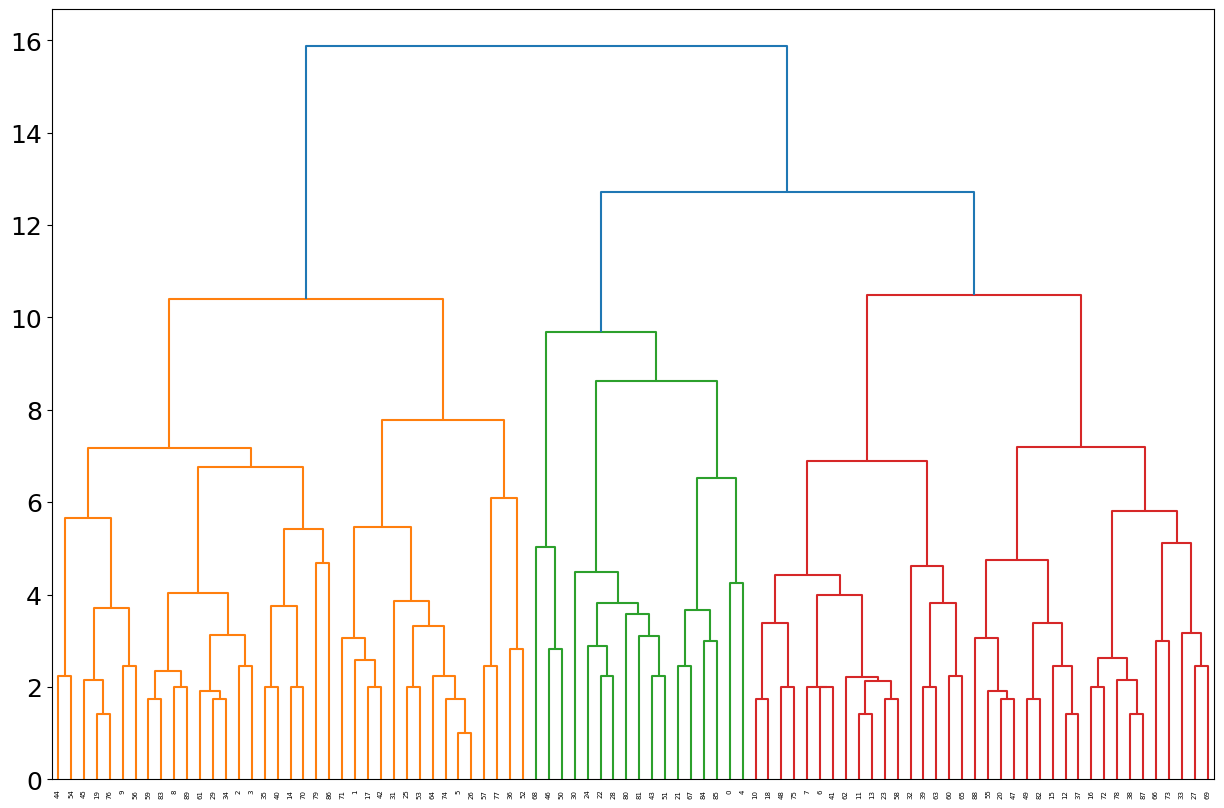

In [17]:
X = akuna_segmentation_data.drop(columns=["SegmentKM","SegmentHC"])

# Plot the hierarchical clustering as a dendrogram.
tree = hierarchy.linkage(X,'ward')
plt.figure(figsize=(15,10))
dn = hierarchy.dendrogram(tree)

Descriptor Analysis
Import Descriptor Data and add segment labels

In [37]:
ita_indices = range(5, 14)
eng_indices = range(58, 67)

clean_names = [
    "Gender", "Occupation", "Region", "Age", 
    "Role", "Frequency", "Ground", "LastPurchase", "ShopPlace"
]
akuna_descriptor_data = pd.DataFrame()

for i in range(len(clean_names)):
    ita_col_name = akuna_data.columns[ita_indices[i]]
    eng_col_name = akuna_data.columns[eng_indices[i]]
    akuna_descriptor_data[clean_names[i]] = akuna_data[eng_col_name].combine_first(akuna_data[ita_col_name])

akuna_descriptor_data.dropna(inplace=True)
print(akuna_descriptor_data.head())

    Gender  Occupation     Region   Age            Role  \
1     Male     Student    Abroad   25.0        Defender   
2  Maschio  Dipendente     Puglia  30.0  Centrocampista   
3     Male     Student    Abroad   29.0      Midfielder   
5  Maschio    Studente     Puglia  24.0       Difensore   
6     Male    Employee  Lombardia  30.0        Defender   

                      Frequency            Ground          LastPurchase  \
1  Between three and ten times   Artificial turf          Less than 80€   
2                   Meno di tre         Sintetico           Meno di 80€   
3        Less than three times   Artificial turf          Less than 80€   
5                   Meno di tre         Sintetico           Meno di 80€   
6        Less than three times   Artificial turf   Between 80€ and 100€   

               ShopPlace  
1  Physical on-site shop  
2     recarti in negozio  
3  Physical on-site shop  
5     recarti in negozio  
6  Physical on-site shop  


In [38]:
encoding_maps = {
    'Gender':{
    'Maschio': 'Male',
    "Male": "Male",
    'Femmina': 'Female',
    "Female":"Female",
    "Preferisco non specificarlo": "Prefer not to say",
    "Prefer not to say": "Prefer not to say"},
    
    'Occupation': {
    'Studente' : 'Student', 'Student' : 'Student',
    'Dipendente' : 'Employee', 'Employee' : 'Employee',
    'Libero professionista' : 'Freelance', 'Freelance' : 'Freelance',
    'Altro' : 'Other', 'Other' : 'Other'},

    'Role': {
    'Difensore' : 'Defender', 'Defender' : 'Defender',
    'Attaccante' : 'Striker', 'Striker' : 'Striker',
    'Portiere' : 'Keeper', 'Keeper' : 'Keeper',
    'Centrocampista' : 'Midfielder', 'Midfielder' : 'Midfielder'},

    'Ground':{
    'Sintetico' : 'Artificial turf ', 'Artificial turf ' : 'Artificial turf ',
    'Naturale' : "Grass", 'Grass' : "Grass",
    'Alterno queste due superfici' : 'Mixed'},

    'ShopPlace':{
    'recarti in negozio':0, 'Physical on-site shop':0,
    'andare online':1},

    'LastPurchase': {
    'Less than 80€': 1, 'Meno di 80€': 1,
    'Between 80€ and 100€': 2, 'Tra gli 80€ e i 100€': 2,
    'Between 100€ and 150€': 3, 'Tra i 100€ e i 150€': 3,
    'More than 150€': 4, 'Più di 150€': 4},

    'Frequency' :{
    'Less than three times ': 1, 'Meno di tre': 1,
    'Between three and ten times ': 2, 'Tra le tre e le dieci': 2, 
    'More than ten times ': 3, 'Più di dieci': 3}
}

# Applicazione delle trasformazioni
for col, mapping in encoding_maps.items():
    if col in akuna_descriptor_data.columns:
        akuna_descriptor_data[col] = akuna_descriptor_data[col].map(mapping)
        
# Verifica i risultati
print(akuna_descriptor_data.head())

  Gender Occupation     Region   Age        Role  Frequency            Ground  \
1   Male    Student    Abroad   25.0    Defender          2  Artificial turf    
2   Male   Employee     Puglia  30.0  Midfielder          1  Artificial turf    
3   Male    Student    Abroad   29.0  Midfielder          1  Artificial turf    
5   Male    Student     Puglia  24.0    Defender          1  Artificial turf    
6   Male   Employee  Lombardia  30.0    Defender          1  Artificial turf    

   LastPurchase  ShopPlace  
1             1          0  
2             1          0  
3             1          0  
5             1          0  
6             2          0  


In [42]:
akuna_descriptor_data["SegmentKM"] = akuna_segmentation_data["SegmentKM"]
print("DataFrame: akuna_descriptor_data (with 'SegmentKM' column added)")
akuna_descriptor_data.head(8)

DataFrame: akuna_descriptor_data (with 'SegmentKM' column added)


,Gender,Occupation,Region,Age,Role,Frequency,Ground,LastPurchase,ShopPlace,SegmentKM
1,Male,Student,Abroad,25.0,Defender,2,Artificial turf,1,0,1
2,Male,Employee,Puglia,30.0,Midfielder,1,Artificial turf,1,0,2
3,Male,Student,Abroad,29.0,Midfielder,1,Artificial turf,1,0,2
5,Male,Student,Puglia,24.0,Defender,1,Artificial turf,1,0,2
6,Male,Employee,Lombardia,30.0,Defender,1,Artificial turf,2,0,3
7,Male,Student,Lombardia,24.0,Striker,3,Artificial turf,1,0,2
9,Male,Student,Liguria,24.0,Defender,1,Artificial turf,2,0,2
13,Male,Student,Liguria,23.0,Midfielder,1,Artificial turf,2,0,3



Segment description

In [59]:
numeric_cols = ['Age', 'LastPurchase', 'ShopPlace'] 

# numeric means per segment
seg_num = akuna_descriptor_data.groupby("SegmentKM")[numeric_cols].mean().T
pop_num = akuna_descriptor_data[numeric_cols].mean()

# Gender quotas per segment
seg_gender = (
    pd.crosstab(akuna_descriptor_data["Gender"], akuna_descriptor_data["SegmentKM"], normalize='columns')
    .rename(index=lambda x: f"Gender={x}")
)

pop_gender = (
    akuna_descriptor_data["Gender"].value_counts(normalize=True)
    .reindex(["Male", "Female", "Prefer not to say"])
)
pop_gender.index = [f"Gender={x}" for x in pop_gender.index]

# Merge: rows as variables, columns as segments 
segments_summary = pd.concat([seg_gender, seg_num], axis=0)
akuna_descriptor_data_Summary = segments_summary.copy()
akuna_descriptor_data_Summary.insert(0, "Population", pd.concat([pop_gender, pop_num]))


In [60]:
def fmt_value(v, idx):
    if isinstance(idx, str) and idx.startswith("Gender="):
        return f"{v:.1%}" if pd.notna(v) else ""
    return f"{v:.1f}" if pd.notna(v) else ""

formatted = akuna_descriptor_data_Summary.copy()

for r in formatted.index:
    formatted.loc[r] = [
        fmt_value(v, r)
        for v in akuna_descriptor_data_Summary.loc[r].values
    ]

In [61]:
def style_cols(col, numeric_df):
    if str(col.name) == "Population":
        return ["background-color: white"] * len(col)

    seg = akuna_descriptor_data[akuna_descriptor_data["SegmentKM"] == col.name]
    rest = akuna_descriptor_data[akuna_descriptor_data["SegmentKM"] != col.name]

    colors = []
    for var in col.index:
        seg_value = numeric_df.loc[var, col.name]   # <-- NUMERICO

        if isinstance(var, str) and var.startswith("Gender="):
            cat = var.split("=", 1)[1]
            a = (seg["Gender"] == cat).sum()
            b = (seg["Gender"] != cat).sum()
            c = (rest["Gender"] == cat).sum()
            d = (rest["Gender"] != cat).sum()

            table = np.array([[a, b], [c, d]])
            _, p_value, _, _ = stats.chi2_contingency(table)

            rest_share = (rest["Gender"] == cat).mean()
        else:
            x = pd.to_numeric(seg[var], errors="coerce")
            y = pd.to_numeric(rest[var], errors="coerce")
            _, p_value = stats.ttest_ind(x, y, nan_policy='omit', equal_var=False)

            rest_share = y.mean()

        if p_value < 0.05:
            color = "background-color: #2ecc71; color: white" if seg_value > rest_share else "background-color: #e74c3c; color: white"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if seg_value > rest_share else "background-color: #f1807e"
        else:
            color = "background-color: white"

        colors.append(color)

    return colors

In [62]:
# Format as percentages for Gender
def fmt_value(v, idx):
    if isinstance(idx, str) and idx.startswith("Gender="):
        return f"{v:.1%}" if pd.notna(v) else ""
    return f"{v:.1f}" if pd.notna(v) else ""

styled_table = formatted.style.apply(style_cols, axis=0, numeric_df=akuna_descriptor_data_Summary)

styled_table


SegmentKM,Population,1,2,3
Gender=Female,4.4%,10.0%,2.2%,4.0%
Gender=Male,93.3%,90.0%,95.6%,92.0%
Gender=Prefer not to say,2.2%,0.0%,2.2%,4.0%
Age,24.5,23.2,25.3,24.3
LastPurchase,1.7,2.1,1.5,1.8
ShopPlace,0.0,0.1,0.0,0.0


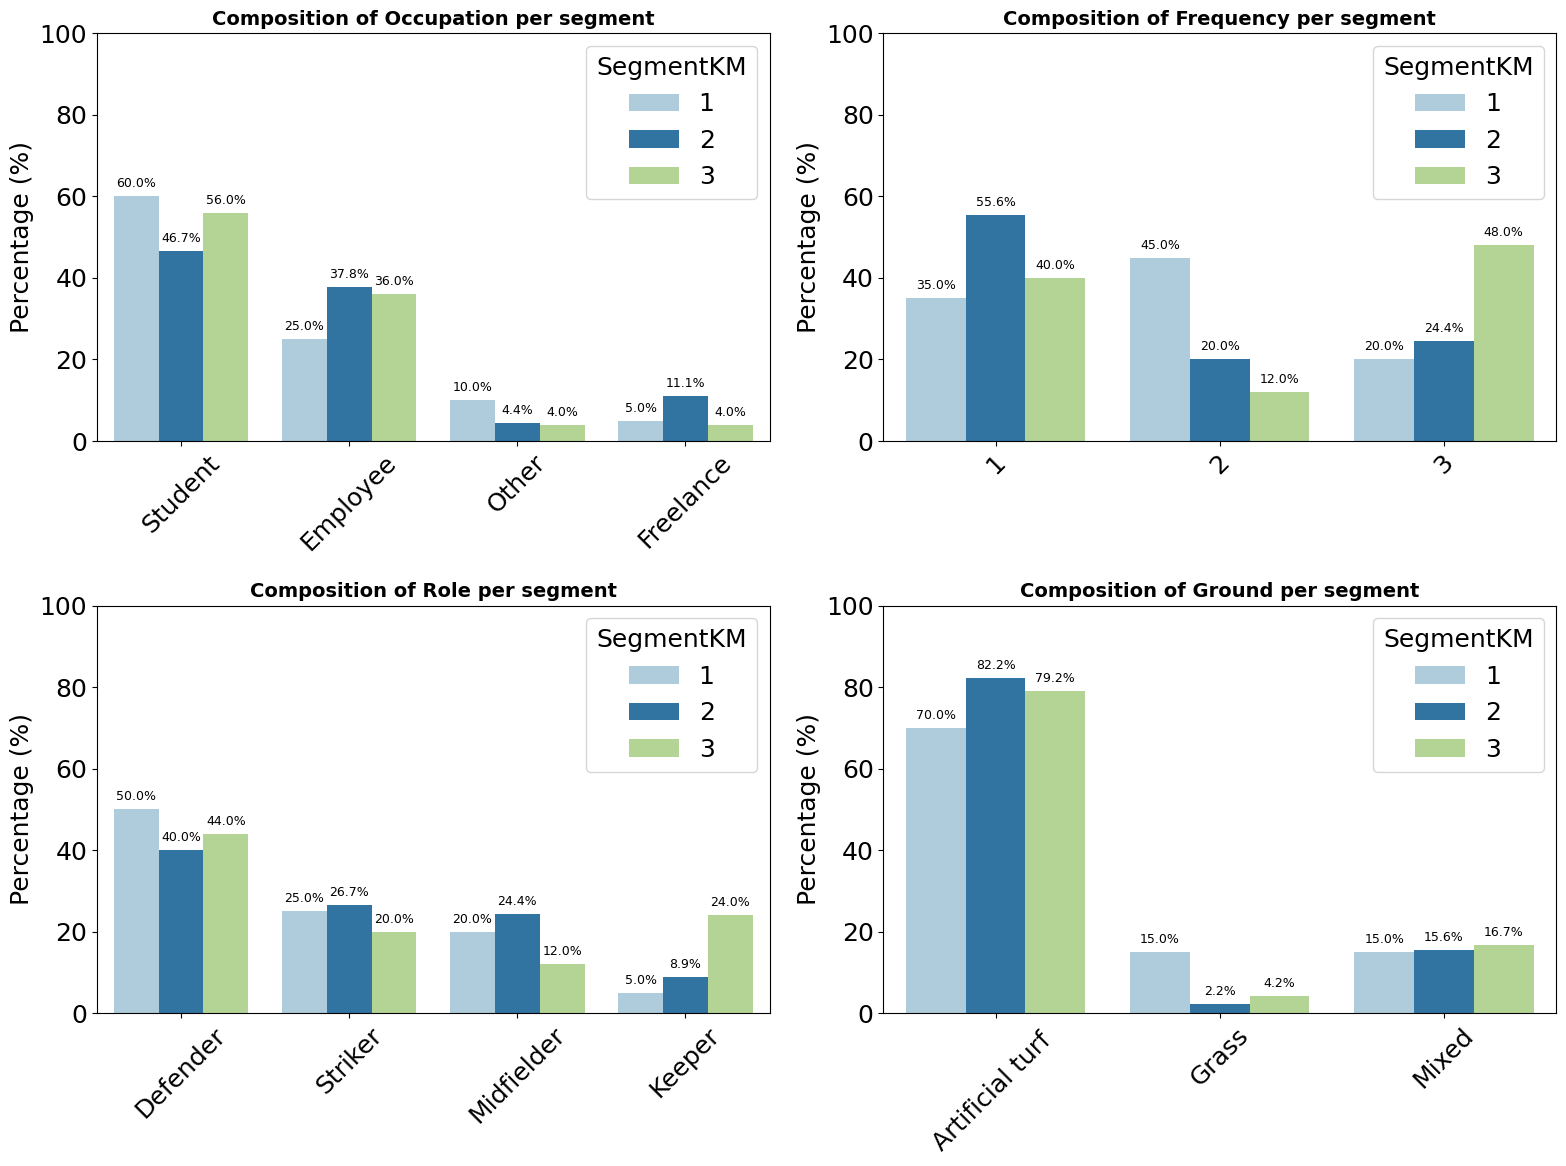

In [63]:
vars_to_plot = ['Occupation', 'Frequency', 'Role', 'Ground']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    prop_df = (akuna_descriptor_data.groupby('SegmentKM')[var]
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())
    
    prop_df['percentage'] *= 100

    sns.barplot(
        data=prop_df, 
        x=var, 
        y='percentage', 
        hue='SegmentKM', 
        ax=axes[i],
        palette='Paired'
    )
    
    axes[i].set_title(f'Composition of {var} per segment', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_ylim(0, 100) 
    axes[i].tick_params(axis='x', rotation=45)
    
    # Aggiunta etichette percentuali sopra le barre (opzionale)
    for p in axes[i].patches:
        if p.get_height() > 0:
            axes[i].annotate(f'{p.get_height():.1f}%', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points',
                             fontsize=9)

plt.tight_layout()
plt.show()

Descriptor Space using PCA (with pca package)

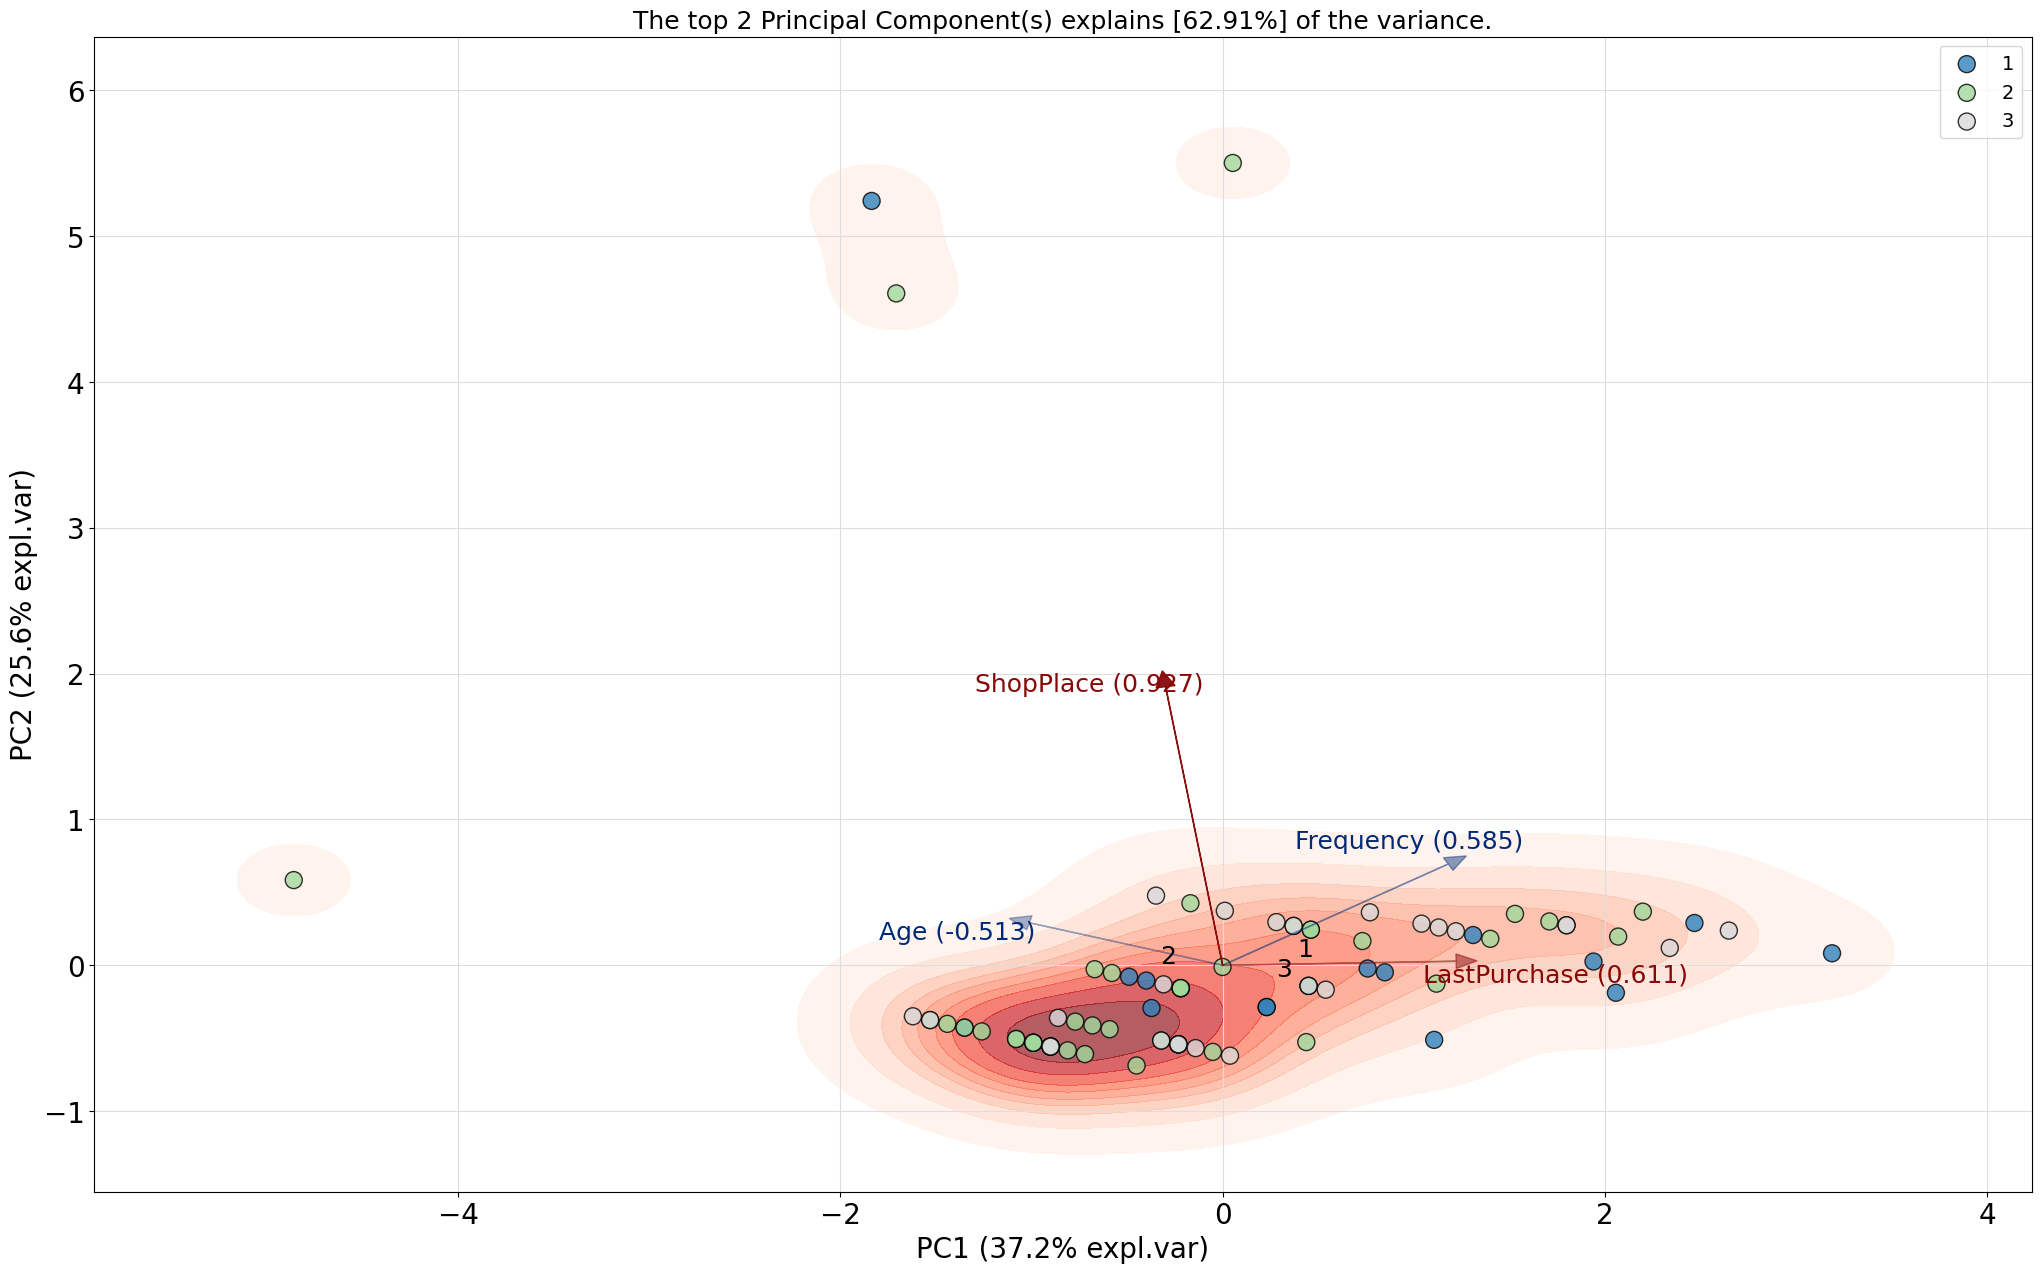

In [64]:
# Produce a PCA Biplot (i.e. PCA plot + Loadings plot) also featuring kernel densities using the pca package (documentation available at https://erdogant.github.io/pca)

cols_for_pca = ['Age', 'LastPurchase', 'Frequency', 'ShopPlace']

features_pca = akuna_descriptor_data[cols_for_pca]

model = pca(n_components=2, normalize=True)
results = model.fit_transform(features_pca, verbose=False)

fig, ax = model.biplot(
    labels=akuna_descriptor_data.SegmentKM, 
    verbose=0, 
    density=True,
    arrowdict={'color': 'red', 'linewidth': 1.5}  )           

We kept out the GEnder variable: even in the case we encoded it in a dummy, we risked gender to dominate the whole variance (as we have little variance in all the other variables). Also, it would make interpretability difficult.

Classification model

Nei prossimi risultati il modello tiene il segmento 1 come baseline

In [65]:
formula = "SegmentKM ~ C(Occupation) + C(Role) + C(Ground) + Age + LastPurchase + Frequency"
model_logit = smf.mnlogit(formula=formula, data=akuna_descriptor_data).fit()
print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.874019
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:              SegmentKM   No. Observations:                   89
Model:                        MNLogit   Df Residuals:                       65
Method:                           MLE   Df Model:                           22
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                  0.1545
Time:                        14:26:26   Log-Likelihood:                -77.788
converged:                       True   LL-Null:                       -92.001
Covariance Type:            nonrobust   LLR p-value:                    0.1620
               SegmentKM=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0668      3.206     -0.021      0.983      

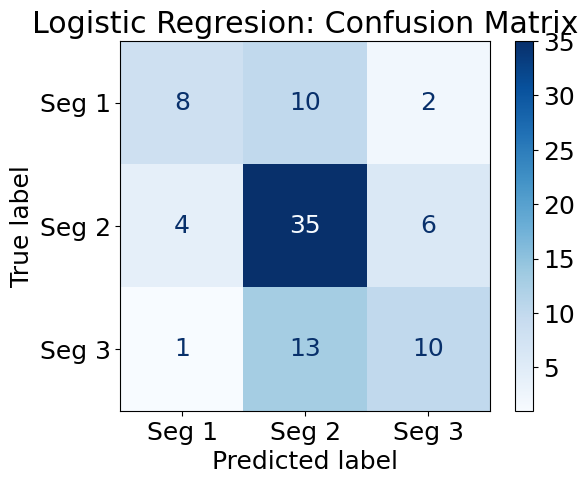

In [66]:
pred_table = model_logit.pred_table()
disp = ConfusionMatrixDisplay(confusion_matrix=pred_table, 
                              display_labels=['Seg 1', 'Seg 2', 'Seg 3'])
disp.plot(cmap='Blues', values_format='.0f')
ax.grid(False)
plt.title("Logistic Regresion: Confusion Matrix")
plt.show()

In [67]:
akuna_descriptor_data["SegmentKM"] = akuna_descriptor_data["SegmentKM"].astype(int)
model_ols = smf.ols(
    "SegmentKM ~ C(Occupation) + C(Role) + C(Ground) + Age + LastPurchase + Frequency",
    data=akuna_descriptor_data
).fit()

print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              SegmentKM   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9930
Date:                Thu, 12 Feb 2026   Prob (F-statistic):              0.460
Time:                        14:26:34   Log-Likelihood:                -88.852
No. Observations:                  89   AIC:                             201.7
Df Residuals:                      77   BIC:                             231.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [68]:

# True labels
y_true = akuna_descriptor_data["SegmentKM"].astype(int)

# Predizioni continue -> classi (1-3)
y_pred_cont = model_ols.predict(akuna_descriptor_data)
y_pred = np.rint(y_pred_cont).astype(int)   # round
y_pred = np.clip(y_pred, 1, 3)              # forza nel range [1,3]

# Confusion matrix
pred_table = confusion_matrix(y_true, y_pred, labels=[1, 2, 3])

disp = ConfusionMatrixDisplay(confusion_matrix=pred_table,
                              display_labels=['Seg 1', 'Seg 2', 'Seg 3'])
disp.plot(cmap='Blues', values_format='.0f')
plt.grid(False)
plt.title("OLS Regression: Confusion Matrix")
plt.show()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

Classification using Random Forest Classifier (from sklearn package)

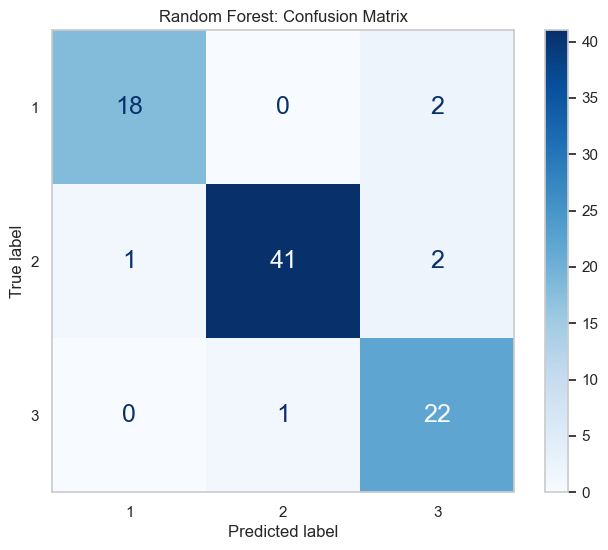

In [82]:
cols_numeric = ['Gender', 'Age', 'LastPurchase', 'Frequency', 'ShopPlace']
cols_nominal = ['Occupation', 'Role', 'Ground']

X = pd.concat([
    akuna_descriptor_data[cols_numeric], 
    pd.get_dummies(akuna_descriptor_data[cols_nominal])
], axis=1)

y = akuna_descriptor_data.SegmentKM

rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(rf, X, y, cmap='Blues', ax=ax)
ax.grid(False) 
plt.title("Random Forest: Confusion Matrix")
plt.show()


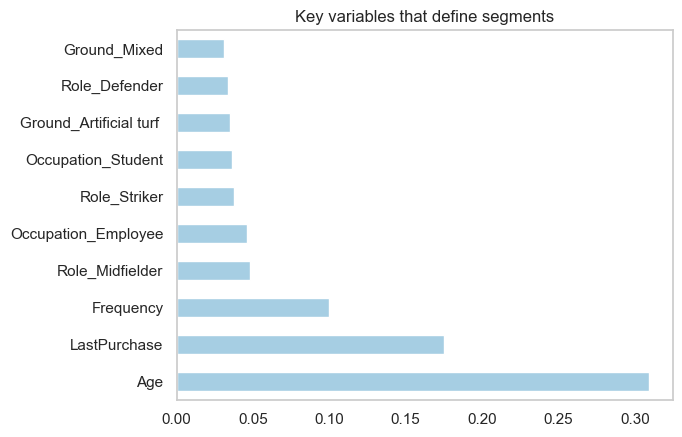

In [86]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(10).plot(kind='barh', cmap='Paired')
plt.title("Key variables that define segments")
plt.gca().grid(False) 
plt.show()

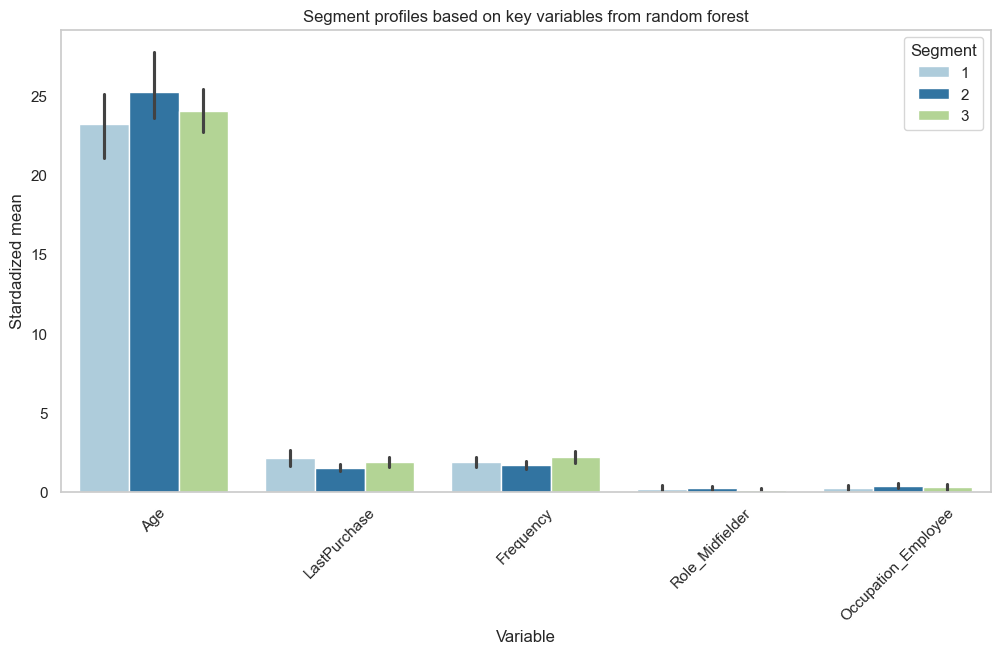

In [87]:
top_features = importances.head(5).index.tolist()

df_plot = X[top_features].copy()
df_plot['Segment'] = y

df_melted = df_plot.melt(id_vars='Segment', var_name='Variable', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Variable', y='Value', hue='Segment', palette='Paired')

plt.title("Segment profiles based on key variables from random forest")
plt.ylabel("Stardadized mean")
plt.xticks(rotation=45)
plt.grid(False) 
plt.show()